# TOMA DE DECISIONES DE NEGOCIOS BASADAS EN ANALISIS DE PRUEBAS A/B Y PRIORIZACION DE HIPÓTESIS

El obejtivo del proyecto es priorizar las hipótesis dadas y realizar un test A/B de los datos recopilados para una tienda online y su respectivo análisis.


## PRIMERA PARTE: Priorización de hipótesis

El objetivo es identificar cual de las hipótesis podría ser la mejor opción para aplicar en primera instancia.

In [1]:
#Importación de librerias necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import timedelta
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

In [2]:
#Revision y lectura del DataSet con el que se trabajara en la primera parte

df_hypothesis=pd.read_csv('/datasets/hypotheses_us.csv', sep=';')

df_hypothesis.head()



,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


###  Parámetro ICE


ICE: (Impact × Confidence) / Effort

In [3]:
#Calculo de ICE

df_hypothesis['ICE']=(df_hypothesis['Impact']*df_hypothesis['Confidence'])/df_hypothesis['Effort']

df_hypothesis

,Hypothesis,Reach,Impact,Confidence,Effort,ICE
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000
3,Change the category structure. This will incre...,8,3,3,8,1.125000
4,Change the background color on the main page. ...,3,1,1,1,1.000000
5,Add a customer review page. This will increase...,3,2,2,3,1.333333
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000


###  Parámetro RICE

RICE: (Reach × Impact × Confidence) / Effort

In [4]:
#Calculo de RICE
df_hypothesis['RICE']=(df_hypothesis['Reach']*df_hypothesis['Impact']*df_hypothesis['Confidence'])/df_hypothesis['Effort']

df_hypothesis

,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2


### Rankings de los 2 parámetros

In [5]:
# Rankings

ice_rank = df_hypothesis.sort_values(by='ICE', ascending=False)
rice_rank = df_hypothesis.sort_values(by='RICE', ascending=False)

display(ice_rank[['Hypothesis', 'ICE']].reset_index(drop=True))
display(rice_rank[['Hypothesis', 'RICE']].reset_index(drop=True))


,Hypothesis,ICE
0,Launch a promotion that gives users discounts ...,16.200000
1,Add two new channels for attracting traffic. T...,13.333333
2,Add a subscription form to all the main pages....,11.200000
3,Show banners with current offers and sales on ...,8.000000
4,Add product recommendation blocks to the store...,7.000000
5,Launch your own delivery service. This will sh...,2.000000
6,Add a customer review page. This will increase...,1.333333
7,Change the category structure. This will incre...,1.125000
8,Change the background color on the main page. ...,1.000000


,Hypothesis,RICE
0,Add a subscription form to all the main pages....,112.0
1,Add product recommendation blocks to the store...,56.0
2,Add two new channels for attracting traffic. T...,40.0
3,Show banners with current offers and sales on ...,40.0
4,Launch a promotion that gives users discounts ...,16.2
5,Change the category structure. This will incre...,9.0
6,Launch your own delivery service. This will sh...,4.0
7,Add a customer review page. This will increase...,4.0
8,Change the background color on the main page. ...,3.0


Se oberva cómo cambian las hipótesis según el parametro que se este evaluando. Mientras que para ICE la mejor hipotesis es "Lanzar una promoción que ofrezca descuentos a los usuarios", para RICE la mejor hipotesis es "Añadir un formulario de suscripción a todas las páginas principales". De esta manera se puede identificar como el factor 'Reach' influye notablemente en la decision de la hipotesis a implementar primero.

## SEGUNDA PARTE: test A/B

### Limpieza y preparación de los datos

In [6]:
#Lectura y visualizacion del dataset orders

df_orders=pd.read_csv('/datasets/orders_us.csv')
df_orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A


In [7]:
#Visualizacion de los tipos de datos y valores ausentes
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [8]:
#Cambio del tipo de dato de la columna date a datetime

df_orders['date']=pd.to_datetime(df_orders['date'])

df_orders.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [9]:
#Lectura y visualizacion del dataset visits

df_visits=pd.read_csv('/datasets/visits_us.csv')
df_visits

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [10]:
#Visualizacion de los tipos de datos y valores ausentes
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [11]:
#Cambio del tipo de dato de la columna date a datetime

df_visits['date']=pd.to_datetime(df_visits['date'])

df_visits.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [12]:
# Verificacion de cuantos usuarios estan en el grupo A 

orders_A = df_orders[df_orders['group'] == 'A']['visitorId'].nunique()
visits_A= df_visits[df_visits['group'] == 'A'].nunique()

print(orders_A)
visits_A

503


date      31
group      1
visits    31
dtype: int64

In [13]:
# Verificacion de cuantos usuarios estan en el grupo B
orders_B= df_orders[df_orders['group']=='B']['visitorId'].nunique()
visits_B= df_visits[df_visits['group'] == 'B'].nunique()

print(orders_B)
visits_B


586


date      31
group      1
visits    30
dtype: int64

El numero total del grupo A y B son diferentes, se esperaria que para este tipo de pruebas se utilizara la misma cantidad de usuarios.

In [14]:
#Encontrar la intersección (usuarios que están en ambos grupos) del df de ordenes

users_A = set(df_orders[df_orders['group'] == 'A']['visitorId'].unique())
users_B = set(df_orders[df_orders['group'] == 'B']['visitorId'].unique())

duplicated_users = users_A.intersection(users_B)

#Contar cuántos hay
print(f"Número de usuarios en ambos grupos de ordenes: {len(duplicated_users)}")

print(duplicated_users)


Número de usuarios en ambos grupos de ordenes: 58
{3957174400, 3984495233, 2780786433, 1294878855, 1648269707, 1614305549, 4120364173, 232979603, 199603092, 4266935830, 2712142231, 2587333274, 2716752286, 3891541246, 1668030113, 2654030115, 3234906277, 1230306981, 1404934699, 3803269165, 2949041841, 237748145, 457167155, 2927087541, 1738359350, 3062433592, 3656415546, 818047933, 393266494, 963407295, 471551937, 2579882178, 3202540741, 2686716486, 1333886533, 2044997962, 3941795274, 1801183820, 2378935119, 4256040402, 4069496402, 3766097110, 8300375, 351125977, 1602967004, 276558944, 2038680547, 3951559397, 3963646447, 4186807279, 3717692402, 1959144690, 2458001652, 2600415354, 2954449915, 1316129916, 477780734, 3972127743}


In [15]:
#Eliminacion de los datos duplicados para conservar la validez estadística del test
df_orders_clean = df_orders[~df_orders['visitorId'].isin(duplicated_users)]
df_orders_clean

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


### Ingreso acumulado por grupo

In [16]:
# Ingreso acumulado
cumulative_revenue = (
    df_orders_clean.groupby(['group', 'date'])['revenue']
    .sum()
    .groupby(level=0)
    .cumsum()
    .reset_index()
)
cumulative_revenue.head()

,group,date,revenue
0,A,2019-08-01,2266.6
1,A,2019-08-02,3734.9
2,A,2019-08-03,5550.1
3,A,2019-08-04,6225.6
4,A,2019-08-05,7623.6


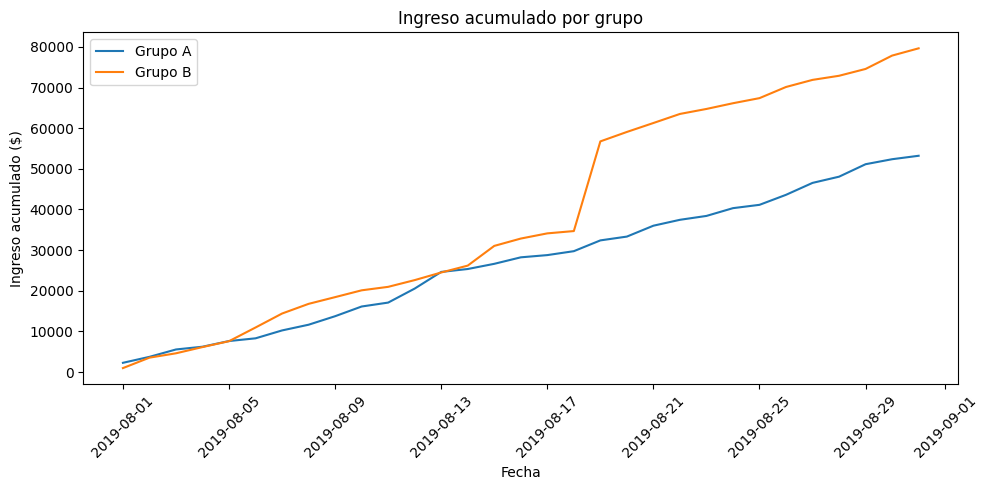

In [17]:
#Grafico del ingreso acumulado
plt.figure(figsize=(10,5))
for grp in ['A', 'B']:
    grp_data = cumulative_revenue[cumulative_revenue['group']==grp]
    plt.plot(grp_data['date'], grp_data['revenue'], label=f'Grupo {grp}')
plt.title('Ingreso acumulado por grupo')
plt.xlabel('Fecha')
plt.ylabel('Ingreso acumulado ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La grafica muestra que el grupo B ha tenido mayores ingresos a medida que transcurre el tiempo, ademas, podemos ver hay ciertos picos  en los ingresos en ciertos puntos sobretodo para el grupo B. Esto puede implicar un aumento en el número de ordenes o la existencia de pedidos muy caros.

### Tamaño de pedido promedio acumulado por grupo

In [18]:
#Se calcula el promedio para cada fecha y grupo
revenue_mean=df_orders_clean.groupby(['group','date'])['revenue'].mean().reset_index()
revenue_mean

,group,date,revenue
0,A,2019-08-01,98.547826
1,A,2019-08-02,77.278947
2,A,2019-08-03,75.633333
3,A,2019-08-04,61.409091
4,A,2019-08-05,63.545455
...,...,...,...
57,B,2019-08-27,158.809091
58,B,2019-08-28,45.931818
59,B,2019-08-29,112.080000
60,B,2019-08-30,156.514286


In [19]:
#Se calcula el promedio acumulativo

revenue_mean['mean_cum']=revenue_mean.groupby('group')['revenue'].expanding().mean().reset_index(level=0, drop=True)
revenue_mean

,group,date,revenue,mean_cum
0,A,2019-08-01,98.547826,98.547826
1,A,2019-08-02,77.278947,87.913387
2,A,2019-08-03,75.633333,83.820036
3,A,2019-08-04,61.409091,78.217299
4,A,2019-08-05,63.545455,75.282930
...,...,...,...,...
57,B,2019-08-27,158.809091,143.326716
58,B,2019-08-28,45.931818,139.848327
59,B,2019-08-29,112.080000,138.890798
60,B,2019-08-30,156.514286,139.478248


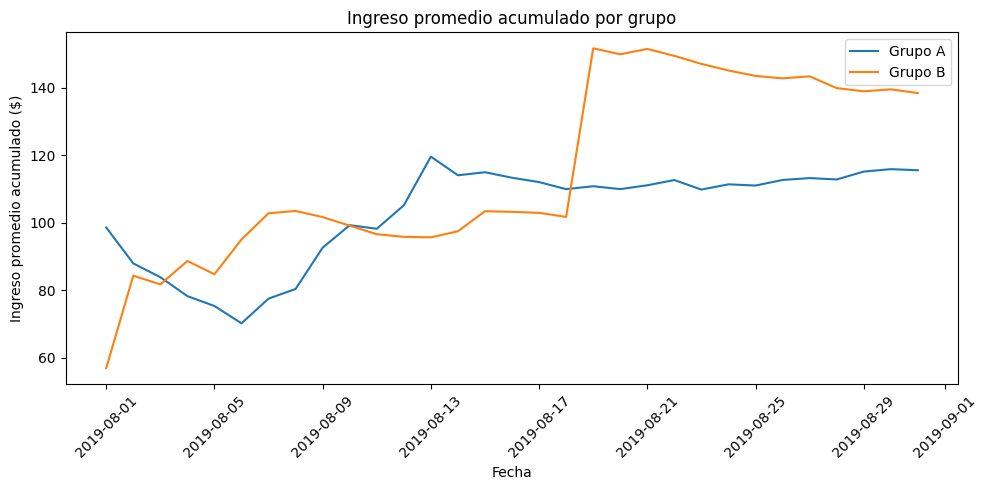

In [20]:
#Grafico del promedio acumulado

plt.figure(figsize=(10,5))
for grp in ['A', 'B']:
    grp_data = revenue_mean[revenue_mean['group']==grp]
    plt.plot(grp_data['date'], grp_data['mean_cum'],label=f'Grupo {grp}')
plt.title('Ingreso promedio acumulado por grupo')
plt.xlabel('Fecha')
plt.ylabel('Ingreso promedio acumulado ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Vemos que para los dos grupos el tamaño promedio tiende a estabilizarse al final. Sin embargo, en ambos grupos se observan picos lo que puede indicar que hubo compras muy altas, lo cual se consideria un outlier, para esto vamos a revisar mas a detalle.

### Diferencia relativa en el tamaño de pedido promedio acumulado (B vs A)

La diferencia relativa la calculamos con el fin de comparar  qué tanto difiere el grupo B del A términos proporcionales, para eso utilizamos la siguiente ecuacion (B - A)/A. Este calculo lo hacemos con el promedio acumulado

In [21]:
#Visualizacion de los promedios acumulados para cada grupo
relative_dif=revenue_mean.pivot_table(index='date', columns='group', values='revenue').reset_index()
relative_dif.head()

group,date,A,B
0,2019-08-01,98.547826,56.894118
1,2019-08-02,77.278947,111.656522
2,2019-08-03,75.633333,76.542857
3,2019-08-04,61.409091,109.400000
4,2019-08-05,63.545455,69.014286


In [22]:
#Calculo de la diferencia relativa
relative_dif['rela_dif']=(relative_dif['B']-relative_dif['A'])/relative_dif['A']
relative_dif.head()

group,date,A,B,rela_dif
0,2019-08-01,98.547826,56.894118,-0.422675
1,2019-08-02,77.278947,111.656522,0.444850
2,2019-08-03,75.633333,76.542857,0.012025
3,2019-08-04,61.409091,109.400000,0.781495
4,2019-08-05,63.545455,69.014286,0.086062


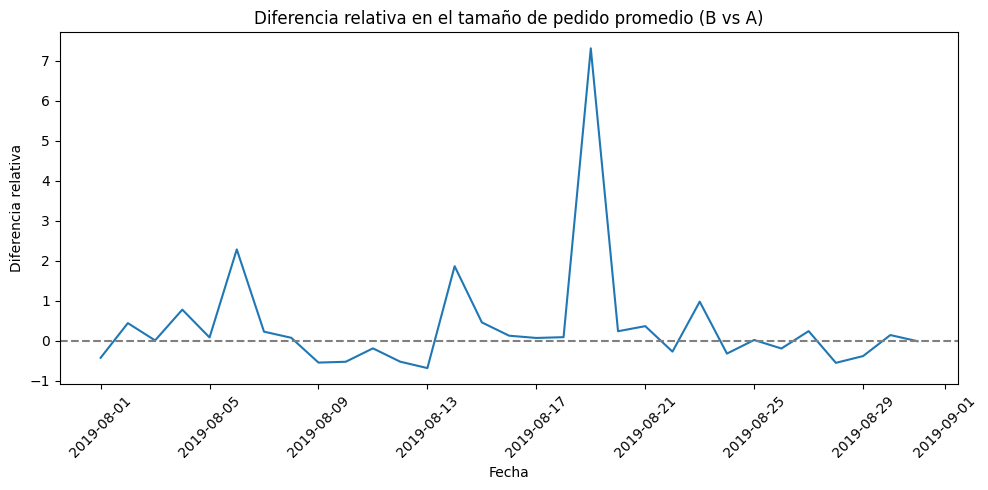

In [23]:
#Grafico de la diferencia relativa del promedio

plt.figure(figsize=(10,5))

plt.plot(relative_dif['date'], relative_dif['rela_dif'])
plt.title('Diferencia relativa en el tamaño de pedido promedio (B vs A)')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Diferencia relativa')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




En general, se ve que el comportamiento del grupo B ha sido favorable con respecto a A, dado que la tendencia en su mayoria se encuentra encima del 0, lo que indica que el promedio de ingresos diariamente es mejor. Sin embargo, en varios puntos, la diferencia entre los segmentos aumenta. Esto significa que puede haber algunos pedidos grandes y valores atípicos

### Tasa de conversión de cada grupo

La tasa de conversión de cada grupo se va a calcular como la relación entre los pedidos y el número de visitas de cada día

In [24]:
# Pedidos por día y grupo
orders_per_day = df_orders_clean.groupby(['group', 'date']).agg({'transactionId':'nunique'}).reset_index()
orders_per_day.rename(columns={'transactionId':'orders'}, inplace=True)

orders_per_day.head()

,group,date,orders
0,A,2019-08-01,23
1,A,2019-08-02,19
2,A,2019-08-03,24
3,A,2019-08-04,11
4,A,2019-08-05,22


In [25]:
# Unimos con el dataset visits
daily = pd.merge(df_visits, orders_per_day, on=['group','date'], how='left').fillna(0)
daily['conversion'] = daily['orders'] / daily['visits']

daily.head()

,date,group,visits,orders,conversion
0,2019-08-01,A,719,23,0.031989
1,2019-08-02,A,619,19,0.030695
2,2019-08-03,A,507,24,0.047337
3,2019-08-04,A,717,11,0.015342
4,2019-08-05,A,756,22,0.029101


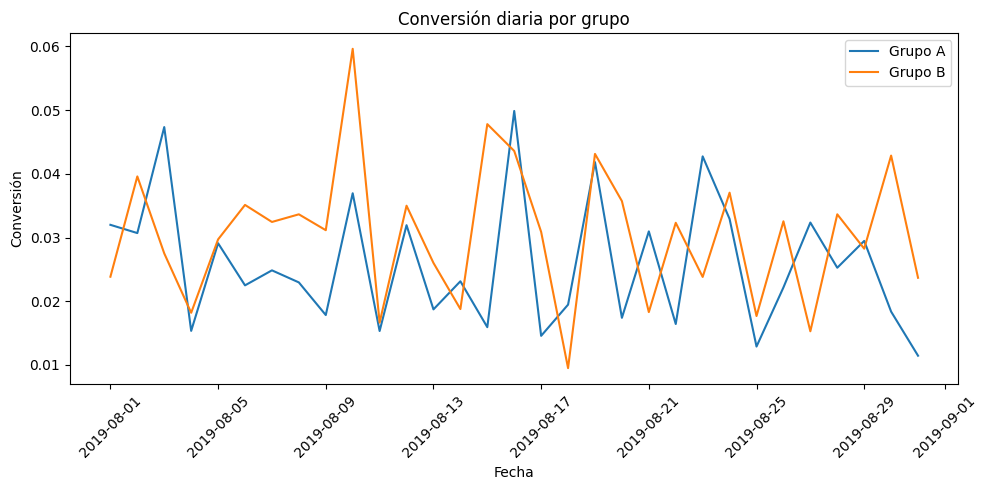

In [26]:
#Grafica de la conversion

plt.figure(figsize=(10,5))
for grp in ['A','B']:
    grp_data = daily[daily['group']==grp]
    plt.plot(grp_data['date'], grp_data['conversion'], label=f'Grupo {grp}')
plt.title('Conversión diaria por grupo')
plt.xlabel('Fecha')
plt.ylabel('Conversión')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El grafico parece que no sigue una tendencia, esto puede deberse por la escala en la que estamos viendo la grafica, o realmente porque los datos son muy variables para ambos grupos en los diferentes dias.

### Gráfico de dispersión del número de pedidos por usuario

In [27]:
#Conteo de numero de pedidos por usuario

orders_per_user = df_orders_clean.groupby('visitorId').agg({'transactionId':'nunique'}).reset_index()
orders_per_user.rename(columns={'transactionId':'orders'}, inplace=True)

orders_per_user.head()

,visitorId,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


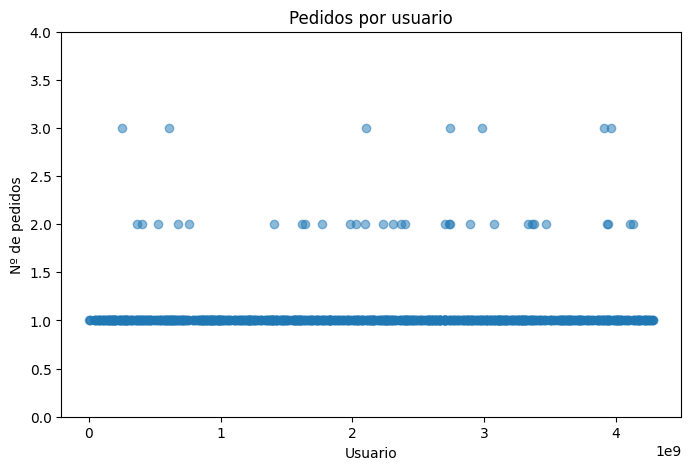

In [28]:
#Grafico de dispersion para los pedidos por cliente
plt.figure(figsize=(8,5))

plt.scatter(orders_per_user['visitorId'], orders_per_user['orders'], alpha=0.5)
plt.title('Pedidos por usuario')
plt.xlabel('Usuario')
plt.ylabel('Nº de pedidos')
plt.ylim(0, orders_per_user['orders'].max()+1)
plt.show()

Podemos observar que la mayoria de los clientes suele pedir solo 1 pedido por dia, sin embargo, se evidencias otros clientes que hacen hasta 3 pedidos por dias

In [29]:
# Calculo de los percentiles del numero de pedidos por usuario

print(np.percentile(orders_per_user['orders'], [ 95, 99]))


[1. 2.]


Despues de 2 pedidos se considera una anomalia, dado que esta por encima del 99

### Gráfico de dispersión de los ingresos por pedido. 

In [30]:
#Calculo de los ingresos por pedido
orders_per_revenue = df_orders_clean.groupby('transactionId').agg({'revenue':'sum'}).reset_index()


orders_per_revenue.head()

,transactionId,revenue
0,1062393,100.8
1,4919758,40.2
2,7210578,60.5
3,8131427,75.5
4,11068804,75.7


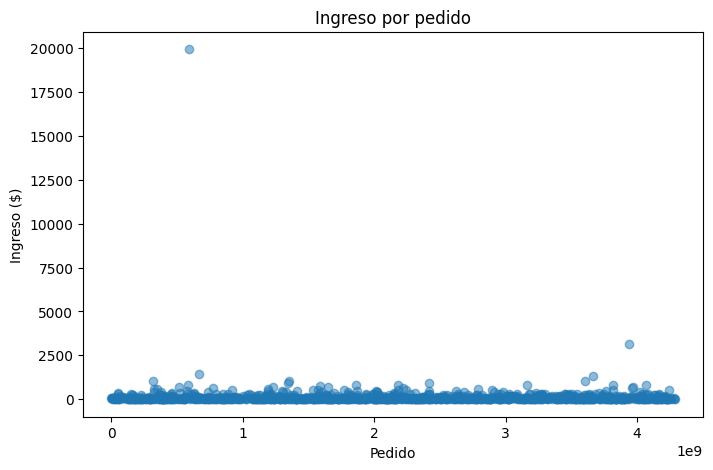

In [31]:
#Grafico de dispersion para los ingresos por pedido
plt.figure(figsize=(8,5))

plt.scatter(orders_per_revenue['transactionId'], orders_per_revenue['revenue'], alpha=0.5)
plt.title('Ingreso por pedido')
plt.xlabel('Pedido')
plt.ylabel('Ingreso ($)')
plt.show()

Hubo un pedido de 20000 dolares que hace que los datos puedan verse afectados, dado que la mayoria fueron de menos de 2500, el outlier nos dificulta ver con precision la tendencia de los datos, por ellos se va a calcular el percentil.

In [32]:
#Calculo del percentil para los ingresos por pedido

print(np.percentile(orders_per_revenue['revenue'], [ 95, 99]))

[414.275 830.3  ]


Despues de 830 dolares por pedido se va a considerar como anomalia.

### Significancia Estadística

#### Diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto

Queremos averiguar si la tasa de conversión del grupo A y del grupo B es estadísticamente diferente

In [33]:
daily.head()

,date,group,visits,orders,conversion
0,2019-08-01,A,719,23,0.031989
1,2019-08-02,A,619,19,0.030695
2,2019-08-03,A,507,24,0.047337
3,2019-08-04,A,717,11,0.015342
4,2019-08-05,A,756,22,0.029101


In [34]:
#Suma del total de ordenes y visitas para cada grupo
conversion=daily.groupby('group').agg({'visits':'sum','orders':'sum'})
conversion

,visits,orders
group,,
A,18736,468
B,18916,548


In [35]:
#Usuarios que compraron en cada grupo
success = conversion['orders']
success

group
A    468
B    548
Name: orders, dtype: int64

In [36]:
#Usuarios totales que visitaron el sitio web
total=conversion['visits']
total

group
A    18736
B    18916
Name: visits, dtype: int64

In [37]:
#Test de proporciones con datos brutos


stat, pval = proportions_ztest(success, total)
print(f'Estadístico z: {stat:.4f}, p-valor: {pval:.4f}')

Estadístico z: -2.3899, p-valor: 0.0169


Un p-valor < 0.05 indica diferencia significativa en la conversión con poca probabilidad que se deba al azar. Ademas, el valor Z tambien nos indica que una diferencia grande dado que el resultado(Z = -2.3) esta lejos del valor esperado(Z = 0). Eso significa que hay una alta probabilidad de que el cambio sí tenga efecto real, no solo por suerte.

#### Diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto.

In [38]:
df_orders_clean.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [39]:
#Filtrar los datos brutos necesarios

group_a=df_orders_clean[df_orders_clean['group']=='A']['revenue']
group_b=df_orders_clean[df_orders_clean['group']=='B']['revenue']

In [40]:
#Verificar si los datos siguen una distribucion normal o no, se va a verificar con la prueba Shapiro

_, p_a = shapiro(group_a)
_, p_b = shapiro(group_b)

print(f'Normalidad grupo A: p = {p_a:.4f}')
print(f'Normalidad grupo B: p = {p_b:.4f}')

Normalidad grupo A: p = 0.0000
Normalidad grupo B: p = 0.0000


Como p<0.05 nos indica que los datos no tienen una distribucion normal, por lo que se utilizara la prueba de Mann-Whitney

In [41]:
#Prueba Mann-Whitney

u_stat, pval_rev = stats.mannwhitneyu(group_a, group_b, alternative='two-sided')
print(f'U estadístico: {u_stat}, p-valor: {pval_rev:.4f}')

U estadístico: 129041.5, p-valor: 0.8622


Como p>0.05 rechazariamos la hipotesis nula que indica que esto significa que no hay evidencia estadística de que los tamaños promedio de pedido entre los grupos A y B sean diferentes

#### Diferencia en la conversión entre los grupos utilizando los datos filtrados

El objetivo de esta parte es repetir el analisis anterior pero eliminando los outliers

In [42]:
df_orders_clean.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [43]:
orders_per_user.head()

,visitorId,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


In [44]:
#Percentil de los pedidos
q99_orders=np.percentile(orders_per_user['orders'], 99)
q99_rev=np.percentile(orders_per_revenue['revenue'], 99)


In [45]:
# Umbrales
orders_threshold = q99_orders
revenue_threshold = q99_rev

print("1", orders_threshold)
print("2", revenue_threshold)

1 2.0
2 830.3


In [46]:
# Extraer usuarios con pedidos anómalos
abnormal_users = orders_per_user[orders_per_user['orders'] > orders_threshold]['visitorId']
abnormal_users

55      249864742
138     611059232
478    2108163459
632    2742574263
687    2988190573
890    3908431265
908    3967698036
Name: visitorId, dtype: int64

In [47]:
#Filtrar los usuarios sin tener en cuenta los usuarios atipicos
filtered_orders = df_orders_clean[~df_orders_clean['visitorId'].isin(abnormal_users) & (df_orders_clean['revenue'] <= revenue_threshold)]
filtered_orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1190,38478481,1197745035,2019-08-14,135.3,B
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A


In [48]:
# Recalcular diarios con datos filtrados
orders_per_day_f = filtered_orders.groupby(['group', 'date']).agg({'transactionId':'nunique'}).reset_index()
orders_per_day_f.rename(columns={'transactionId':'orders'}, inplace=True)
daily_f = pd.merge(df_visits, orders_per_day_f, on=['group','date'], how='left').fillna(0)
daily_f['conversion'] = daily_f['orders'] / daily_f['visits']
daily_f.head()

,date,group,visits,orders,conversion
0,2019-08-01,A,719,18,0.025035
1,2019-08-02,A,619,18,0.029079
2,2019-08-03,A,507,24,0.047337
3,2019-08-04,A,717,11,0.015342
4,2019-08-05,A,756,22,0.029101


In [49]:
#Calculo de las ordenes y visitas totales
conversions_f = daily_f.groupby('group').agg({'orders':'sum', 'visits':'sum'})
conversions_f

,orders,visits
group,,
A,448,18736
B,538,18916


In [50]:
#total de compras despues de filtrado
success_f = conversions_f['orders']
success_f

group
A    448
B    538
Name: orders, dtype: int64

In [51]:
#total de visitas despues de filtrado
total_f = conversions_f['visits']
total_f

group
A    18736
B    18916
Name: visits, dtype: int64

In [52]:
#Test de proporciones con datos filtrados
stat_f, pval_f = proportions_ztest(conversions_f['orders'], conversions_f['visits'])
print(f'Conversión filtrada - z: {stat_f:.4f}, p-valor: {pval_f:.4f}')

Conversión filtrada - z: -2.7524, p-valor: 0.0059


Un p-valor < 0.05 indica diferencia significativa en la conversión con poca probabilidad que se deba al azar. Ademas, el valor Z tambien nos indica que una diferencia grande dado que el resultado(Z = -2.3) esta lejos del valor esperado(Z = 0). Eso significa que hay una alta probabilidad de que el cambio sí tenga efecto real, no solo por suerte.

#### Diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados

In [53]:
a_rev_f = filtered_orders[filtered_orders['group']=='A']['revenue']
b_rev_f = filtered_orders[filtered_orders['group']=='B']['revenue']
u_stat_f, pval_rev_f = stats.mannwhitneyu(a_rev_f, b_rev_f, alternative='two-sided')
print(f'Ticket promedio filtrado - U: {u_stat_f}, p-valor: {pval_rev_f:.4f}')

Ticket promedio filtrado - U: 121514.0, p-valor: 0.8220


Como p>0.05 rechazariamos la hipotesis nula que indica que esto significa que no hay evidencia estadística de que los tamaños promedio de pedido entre los grupos A y B sean diferentes

In [54]:
#Encontrar el ingreso promedio acumulado para los datos filtrados
filtered_mean=filtered_orders.sort_values(by=['date','group'])
filtered_mean

,transactionId,visitorId,date,revenue,group
55,1144701458,1143609305,2019-08-01,45.3,A
72,477940151,1422773200,2019-08-01,15.8,A
73,1295850747,2947100995,2019-08-01,455.8,A
96,1170105516,2706377257,2019-08-01,140.8,A
98,1962247337,2706377257,2019-08-01,110.7,A
...,...,...,...,...,...
1023,2886170101,930758570,2019-08-31,105.7,B
1024,3845118557,1964413493,2019-08-31,5.5,B
1026,853409662,1390677121,2019-08-31,290.5,B
1037,4149581711,1555048873,2019-08-31,30.2,B


In [55]:
# Ingreso acumulado
cumulative_revenue = (
    df_orders_clean.groupby(['group', 'date'])['revenue']
    .sum()
    .groupby(level=0)
    .cumsum()
    .reset_index()
)
cumulative_revenue.head()

,group,date,revenue
0,A,2019-08-01,2266.6
1,A,2019-08-02,3734.9
2,A,2019-08-03,5550.1
3,A,2019-08-04,6225.6
4,A,2019-08-05,7623.6


In [56]:
#Calculo del ingreso acumulado de los datos filtrados
revenue_mean_filtered=filtered_mean.groupby(['group','date'])['revenue'].mean().reset_index()
revenue_mean_filtered

,group,date,revenue
0,A,2019-08-01,98.850000
1,A,2019-08-02,79.905556
2,A,2019-08-03,75.633333
3,A,2019-08-04,61.409091
4,A,2019-08-05,63.545455
...,...,...,...
57,B,2019-08-27,41.130000
58,B,2019-08-28,45.931818
59,B,2019-08-29,112.080000
60,B,2019-08-30,156.514286


In [57]:
#Visualizacion de los promedios acumulados para cada grupo de los datos filtrados
relative_dif_filt=revenue_mean_filtered.pivot_table(index='date', columns='group', values='revenue').reset_index()
relative_dif_filt.head()

group,date,A,B
0,2019-08-01,98.850000,56.894118
1,2019-08-02,79.905556,111.656522
2,2019-08-03,75.633333,76.542857
3,2019-08-04,61.409091,109.400000
4,2019-08-05,63.545455,69.014286


In [58]:
#Calculo de la diferencia relativa
relative_dif_filt['rela_dif']=(relative_dif_filt['B']-relative_dif_filt['A'])/relative_dif_filt['A']
relative_dif_filt.head()

group,date,A,B,rela_dif
0,2019-08-01,98.850000,56.894118,-0.424440
1,2019-08-02,79.905556,111.656522,0.397356
2,2019-08-03,75.633333,76.542857,0.012025
3,2019-08-04,61.409091,109.400000,0.781495
4,2019-08-05,63.545455,69.014286,0.086062


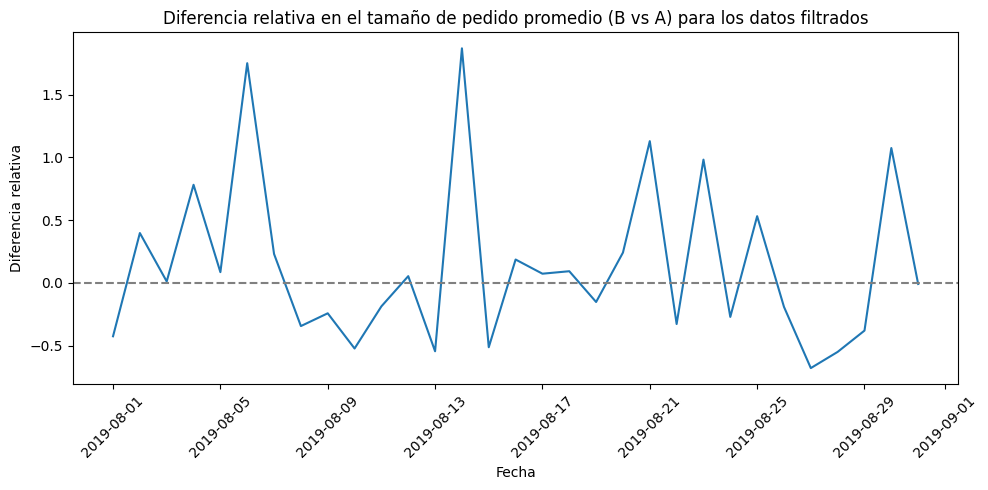

In [59]:
#Grafico de la diferencia relativa del promedio

plt.figure(figsize=(10,5))

plt.plot(relative_dif_filt['date'], relative_dif_filt['rela_dif'])
plt.title('Diferencia relativa en el tamaño de pedido promedio (B vs A) para los datos filtrados')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Diferencia relativa')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [60]:
#Calculo del ingreso promedio de los usuarios para cada grupo

conversions_f['conversion']=conversions_f['orders']/conversions_f['visits']
conversions_f

,orders,visits,conversion
group,,,
A,448,18736,0.023911
B,538,18916,0.028442


In [61]:
#Ingreso promedio total 
total_revenue_mean_filtered=filtered_mean.groupby('group')['revenue'].mean().reset_index()
total_revenue_mean_filtered

,group,revenue
0,A,102.896429
1,B,99.614126


In [62]:
#Ingresos por usuario (Revenue per user RPU)

RPU=pd.merge(conversions_f,total_revenue_mean_filtered, how='inner', on='group')
RPU['rpu']=RPU['conversion']*RPU['revenue']
RPU

,group,orders,visits,conversion,revenue,rpu
0,A,448,18736,0.023911,102.896429,2.460376
1,B,538,18916,0.028442,99.614126,2.833178


Esta ultima metrica indica que, se esta generando un poco mas de dinero con B que con A

# Conclusiones


-Tanto para los datos en crudo como para los datos filtrados el test de proporciones nos indica que la conversion del grupo B es mayor que la del grupo A. Lo que indica que los usuarios del grupo B compran mas que los del grupo A

-De igual forma, para ambos grupos de datos, tanto los crudo como los que no consideran outliers, la prueba de Mann-Whiteny nos indica que no hay diferencia significativa en el promedio entre quienes compraron en el grupo A y B.

-El resultado de la prueba puede ser un poco contradictorio porque una prueba nos muestra que B puede ser mejor, pero la otra nos indica que no necesariamente, lo que sugiere que la decision depende del enfoque que la empresa quiera tener, si desea mejorar las tasas de conversion o los ingresos por usuario, el grupo B puede ser la mejor opcion, pero si lo que se desea es aumentar el valor del pedido promedio no hay evidencia suficiente para decir que B es mejor que A y en ese caso habria que parar la prueba.